In [124]:
!pip install torch
!pip install matplotlib
!pip install yfinance
!pip install numpy

import numpy as np
from matplotlib import pyplot as plt

In [125]:
import yfinance as yf

#ONLY CHANGE THINGS INSIDE HERE

stockChosenTicker = "NVDA"
inputBatchSize = 100
outputBatchSize = 10
numberOfEpochs = 500
learningRate = 0.001
dropout = 0.1

#ONLY CHANGE THINGS INSIDE HERE


stockChosen = yf.Ticker(stockChosenTicker)

df = stockChosen.history(period="10y")

df.drop(columns=['Stock Splits'], inplace=True)

df.drop(columns=['Dividends'], inplace=True)

X, y = df.drop(columns=['Close']), df.Close.values

stockChosenShowingFinancials = stockChosen
print(stockChosenShowingFinancials.income_stmt.drop(index=['Interest Income Non Operating','EBITDA','Tax Effect Of Unusual Items', 'Tax Rate For Calcs','Normalized EBITDA','Total Unusual Items', 'Total Unusual Items Excluding Goodwill', 'Net Income From Continuing Operation Net Minority Interest', 'Reconciled Depreciation','Reconciled Cost Of Revenue', 'EBIT', 'Net Interest Income', 'Interest Expense','Interest Income', 'Normalized Income', 'Net Income From Continuing And Discontinued Operation', 'Total Operating Income As Reported', 'Diluted Average Shares', 'Basic Average Shares','Diluted EPS', 'Diluted NI Availto Com Stockholders', 'Net Income Common Stockholders', 'Net Income Including Noncontrolling Interests', 'Net Income Continuous Operations', 'Tax Provision', 'Pretax Income', 'Other Income Expense', 'Other Non Operating Income Expenses', 'Special Income Charges', 'Restructuring And Mergern Acquisition', 'Net Non Operating Interest Income Expense','Interest Expense Non Operating', 'Operating Income', 'Operating Expense', 'Research And Development', 'Selling General And Administration', 'Gross Profit', "Cost Of Revenue", 'Operating Revenue']))


#ALSO RECORD THESE FINANCIAL DATA POINTS

                   2024-01-31     2023-01-31     2022-01-31     2021-01-31
Total Expenses  27950000000.0  21397000000.0  16873000000.0  12143000000.0
Basic EPS               12.05           1.76           3.91          1.755
Net Income      29760000000.0   4368000000.0   9752000000.0   4332000000.0
Total Revenue   60922000000.0  26974000000.0  26914000000.0  16675000000.0


In [126]:
"""
plt.plot(y)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("price over time")
plt.savefig("initial_plot.png", dpi=250)
plt.show();
"""

'\nplt.plot(y)\nplt.xlabel("Time")\nplt.ylabel("Price")\nplt.title("price over time")\nplt.savefig("initial_plot.png", dpi=250)\nplt.show();\n'

In [127]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1, 1))

"""
print("X shape is:", X.shape)
print("y is:", y)
print("X shape after fit transform is:", X_trans.shape)
print("y after fit transform is:", y_trans)

print(X_trans.shape)
print(y_trans.shape)
print(X_trans[-20:][0])
"""

'\nprint("X shape is:", X.shape)\nprint("y is:", y)\nprint("X shape after fit transform is:", X_trans.shape)\nprint("y after fit transform is:", y_trans)\n\nprint(X_trans.shape)\nprint(y_trans.shape)\nprint(X_trans[-20:][0])\n'

In [128]:
# split a multivariate sequence past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list() # instantiate X and y
    for i in range(len(input_sequences)):
        # find the end of the input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(input_sequences): break
        # gather input and output of the pattern
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix:out_end_ix, -1]
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = split_sequences(X_trans, y_trans, inputBatchSize, outputBatchSize)

"""
print("X_ss is:", X_ss)
print("X_trans is:", X_trans[-15:])

print("y_ss is:", y_mm)
print("y_trans is:", y_trans[100])



print("X_ss shape is:", X_ss.shape)


print("y_ss shape is:", y_mm.shape)

"""





'\nprint("X_ss is:", X_ss)\nprint("X_trans is:", X_trans[-15:])\n\nprint("y_ss is:", y_mm)\nprint("y_trans is:", y_trans[100])\n\n\n\nprint("X_ss shape is:", X_ss.shape)\n\n\nprint("y_ss shape is:", y_mm.shape)\n\n'

In [129]:

X_train = X_ss[:-150]
X_test = X_ss[-150:]

y_train = y_mm[:-150]
y_test = y_mm[-150:]



In [130]:
import torch

X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [131]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,
                                      (X_train_tensors.shape[0], inputBatchSize,
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,
                                     (X_test_tensors.shape[0], inputBatchSize,
                                      X_test_tensors.shape[2]))

In [132]:
import torch.nn as nn

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # number of features/outputs in hidden state
        # LSTM model
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout) # lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) # fully connected
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self,x):
        # hidden state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # cell state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [133]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train, X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss, i.e backprop
        #test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)

        #commenting out as the dummies may get confused
        """
        if epoch % 10 == 0:
          print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(), test_loss.item()))
        """


In [134]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = numberOfEpochs-150 # 1000-150 epochs
learning_rate = learningRate # 0.001 lr

#HAVE CHANGED FROM 4 TO 5 TO SEE IF FIT THROWN
input_size = 4 # number of features
hidden_size = 2 # number of features/outputs in hidden state(short-term memory)
num_layers = 1 # number of stacked lstm layers

num_classes = outputBatchSize # number of output classes (timesteps)

train_and_review_lstm = LSTM(num_classes,
              input_size,
              hidden_size,
              num_layers)

In [135]:
loss_fn = torch.nn.MSELoss()    #mean-squared error for regression
optimiser = torch.optim.Adam(train_and_review_lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=train_and_review_lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

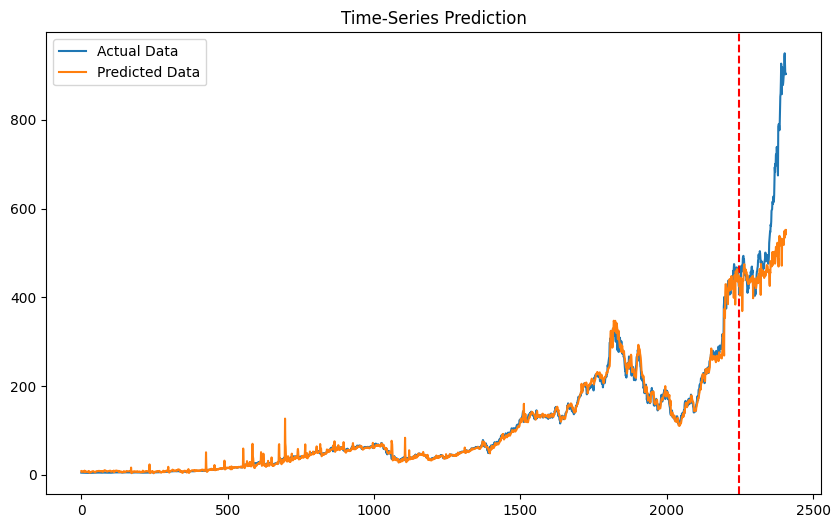

In [136]:
testing_X_trans = ss.transform(df.drop(columns=['Close'])) # old transformers
testing_y_trans = mm.transform(df.Close.values.reshape(-1, 1)) # old transformers

"""
print(testing_X_trans.shape)
print(testing_y_trans.shape)
"""

# split the sequence
testing_X_trans, testing_y_trans = split_sequences(testing_X_trans, testing_y_trans, 100, 10)

"""
print(testing_X_trans.shape)
print(testing_y_trans.shape)
"""


# converting to tensors
testing_X_trans = torch.Tensor(testing_X_trans)
testing_y_trans = torch.Tensor(testing_y_trans)


# reshaping the dataset
testing_X_trans = torch.reshape(testing_X_trans, (testing_X_trans.shape[0], inputBatchSize, testing_X_trans.shape[2]))

"""
print(testing_X_trans.shape)
print(testing_y_trans.shape)
"""

train_predict = train_and_review_lstm(testing_X_trans) # forward pass

"""
print("train predict is:", train_predict)
print("shape of train predict is:", train_predict.shape)

"""

data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = testing_y_trans.data.numpy()

"""

print("shape of data predict is:", data_predict.shape)
print("shape of dataY plot is:", dataY_plot.shape)
"""

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
"""
print("shape of data predict is:", data_predict.shape)
print("shape of dataY plot is:", dataY_plot.shape)

print("data predict is:", data_predict)
print("dataY plot is:", dataY_plot)

print("len datay plot is:", len(dataY_plot))
"""
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
#for i in range(1,len(dataY_plot[-1])):
    #true.append(dataY_plot[-1][i])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
#for i in range(1,len(data_predict[-1])):
    #true.append(data_predict[-1][i])


plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=len(dataY_plot)-160, c='r', linestyle='--') # size of the training set
plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()


In [137]:
"""
print(X_test_tensors_final.shape)
test_predict = train_and_review_lstm(X_test_tensors_final[0].unsqueeze(0)) # get the last sample, was X_test_tensors_final[-1].unsqueeze()
print(test_predict.shape)

test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[0].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.savefig("small_plot.png", dpi=300)
plt.axvline(x=0, c='r', linestyle='--')
plt.show();
"""

'\nprint(X_test_tensors_final.shape)\ntest_predict = train_and_review_lstm(X_test_tensors_final[0].unsqueeze(0)) # get the last sample, was X_test_tensors_final[-1].unsqueeze()\nprint(test_predict.shape)\n\ntest_predict = test_predict.detach().numpy()\ntest_predict = mm.inverse_transform(test_predict)\ntest_predict = test_predict[0].tolist()\n\ntest_target = y_test_tensors[0].detach().numpy() # last sample again\ntest_target = mm.inverse_transform(test_target.reshape(1, -1))\ntest_target = test_target[0].tolist()\n\nplt.plot(test_target, label="Actual Data")\nplt.plot(test_predict, label="LSTM Predictions")\nplt.savefig("small_plot.png", dpi=300)\nplt.axvline(x=0, c=\'r\', linestyle=\'--\')\nplt.show();\n'

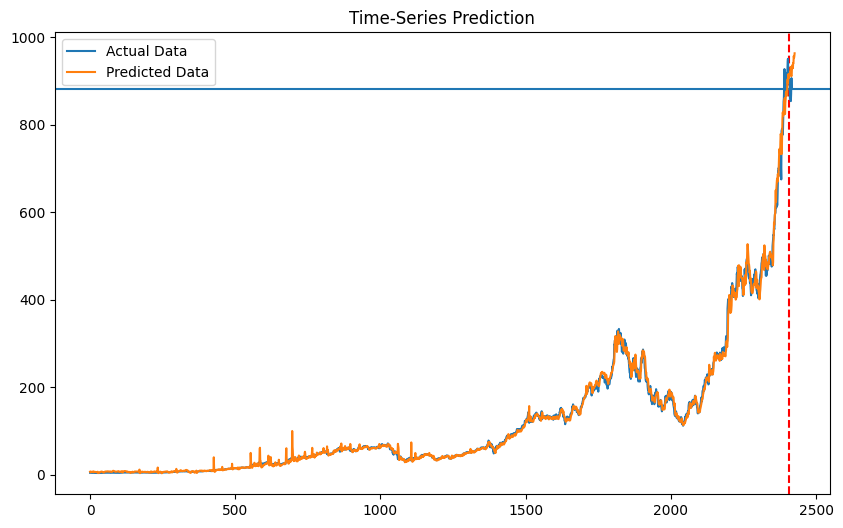

[903.63   894.52   889.64   859.05   880.08   871.33   853.5399 870.39
 906.16   881.86  ]


FOR VIEWING ONLY BY MD OR VP'S

STRICTLY NO BUSINESS INSIGHT DAY ATTENDEES ALLOWED


*Predicted prices for the next ten days*
962.7302
*Predicted prices for the next ten days*


END OF PREDICTIONS




In [144]:

X_actual_test_tensors, y_actual_test_tensors = split_sequences(X_trans, y_trans, inputBatchSize, outputBatchSize)

X_actual_test_tensors = torch.Tensor(X_actual_test_tensors)
y_actual_test_tensors = torch.Tensor(y_actual_test_tensors)

n_epochs = 150

"""
training_loop(n_epochs=n_epochs,
              lstm=train_and_review_lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_actual_test_tensors,
              y_train=y_actual_test_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)
"""

X_actual_prediction, empty = split_sequences(X_trans, y_trans, inputBatchSize, 0)

X_actual_prediction = torch.Tensor(X_actual_prediction)


X_actual_prediction = torch.reshape(X_actual_prediction, (X_actual_prediction.shape[0], inputBatchSize, X_actual_prediction.shape[2]))

actual_predict = train_and_review_lstm(X_actual_prediction) # forward pass

"""
print("train predict is:", actual_predict)
"""

data_predict = actual_predict.data.numpy() # numpy conversion
dataY_plot = testing_y_trans.data.numpy()

"""
print(data_predict.shape)
print(dataY_plot.shape)
"""

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)


"""
print("data predict is;", data_predict)
print("datay is:", dataY_plot)
"""

true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(1,len(dataY_plot[-1])):
    true.append(dataY_plot[-1][i])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
for i in range(1,len(data_predict[-1])):
    preds.append(data_predict[-1][i])


plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=len(dataY_plot), c='r', linestyle='--') # size of the training set
plt.axhline(y=dataY_plot[-1][-1])
plt.plot(true, label='Actual Data') # actual plot
plt.plot(preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.savefig("whole_plot.png", dpi=300)
plt.show()

print(dataY_plot[-1])

print("""

FOR VIEWING ONLY BY MD OR VP'S

STRICTLY NO BUSINESS INSIGHT DAY ATTENDEES ALLOWED

""")
print("*Predicted prices for the next ten days*")
print(data_predict[-1][-1])
print("*Predicted prices for the next ten days*")

print("""

END OF PREDICTIONS

""")

#RECORD THESE PREDICTIONS